In [25]:
from copy import copy
import numpy as np
import random
import matplotlib.pyplot as plt
import matplotlib
#Setting Font Size as 20
matplotlib.rcParams.update({'font.size': 20})

def forward(trans_prob, emm_prob, observations, states, start_prob):
    n = len(observations)
    alpha = [None] * n
    alpha[0] = copy(start_prob)
    for i in range(1, n):
        observation = observations[i]
        cur_a = {}
        prev_a = alpha[i - 1]
        for state in states:
            trans_sum = sum(prev_a[v] * trans_prob[v].get(state, 0)
                            for v in states)
            cur_a[state] = trans_sum * emm_prob[state].get(observation, 0)
        alpha[i] = cur_a
    return alpha


def backward(trans_prob, emm_prob, observations, states, end_st):
    n = len(observations)
    betta = [None] * n
    betta[n - 1] = {v: trans_prob[v].get(end_st, 0) for v in states}
    for i in range(n - 2, -1, -1):
        observation = observations[i]
        cur_b = {}
        prev_b = betta[i + 1]
        for state in states:
            cur_b[state] = sum(prev_b[v] * trans_prob[state].get(v, 0) 
                               * emm_prob[v].get(observation, 0)
                               for v in states)
        betta[i] = cur_b
    return betta


def forward_backward(trans_prob, emm_prob, observations, states, start_prob, end_st):
    frwrd = forward(trans_prob, emm_prob, observations, states, start_prob)
    bcwrd = backward(trans_prob, emm_prob, observations, states, end_st)

    norm = sum(frwrd[-1][k] * trans_prob[k][end_st] for k in states)
    n = len(observations)
    posterior = [None] * n
    for i in range(n):
        posterior[i] = {
            state: frwrd[i][state] * bcwrd[i][state] / norm
            for state in states
        }

    return posterior

# Helps visualize the steps of Viterbi.
def print_dptable(V):
    s = "    " + " ".join(("%7d" % i) for i in range(len(V))) + "\n"
    for y in V[0]:
        s += "%.5s: " % y
        s += " ".join("%.7s" % ("%f" % v[y]) for v in V)
        s += "\n"
    print(s)

def viterbi(obs, states, start_p, trans_p, emit_p):
    V = [{}]
    path = {}
 
    # Initialize base cases (t == 0)
    for y in states:
        V[0][y] = start_p[y] * emit_p[y][obs[0]]
        path[y] = [y]
 
    # V = [{y:(start_p[y] * emit_p[y][obs[0]]) for y in states}]
    # path = {y:[y] for y in states}
 
    # Run Viterbi for t > 0
    for t in range(1, len(obs)):
        V.append({})
        newpath = {}
 
        for y in states:
            (prob, state) = max((V[t-1][y0] * trans_p[y0][y] 
                                 * emit_p[y][obs[t]], y0) for y0 in states)
            V[t][y] = prob
            newpath[y] = path[state] + [y]
 
        # Don't need to remember the old paths
        path = newpath
 
    print_dptable(V)
    (prob, state) = max((V[t][y], y) for y in states)
    return (prob, path[state])

if __name__ == '__main__':
    states = ('F', 'L')
    end_state = 'E'

    observations = ('e1', 'e2', 'e3', 'e4', 'e5', 'e6')

    start_probability = {'F': 0.5, 'L': 0.5}

    transition_probability = {
        'F': {'F': 0.95, 'L': 0.05, 'E': 0.01},
        'L': {'F': 0.1, 'L': 0.9, 'E': 0.01},
    }

    emission_probability = {
        'F': {'e1': 1/6, 'e2': 1/6, 'e3': 1/6, 'e4': 1/6, 'e5': 1/6, 'e6': 1/6},
        'L': {'e1': 0.1, 'e2': 0.1, 'e3': 0.1, 'e4': 0.1, 'e5': 0.1, 'e6': 0.5},
    }

In [26]:
#Viterbi results
def viterbi_results():
    return viterbi(observations,
                    states,
                    start_probability,
                    transition_probability,
                     emission_probability)
print(viterbi_results())


          0       1       2       3       4       5
F: 0.08333 0.01319 0.00208 0.00033 0.00005 0.00000
L: 0.05000 0.00450 0.00040 0.00003 0.00000 0.00000

(8.29240545160322e-06, ['F', 'F', 'F', 'F', 'F', 'F'])


In [27]:
    #Posterior Decoding Results
    posterior = forward_backward(transition_probability,
                                 emission_probability,
                                 observations,
                                 states,
                                 start_probability,
                                 end_state)

    print(*posterior, sep='\n')

{'F': 0.5563224360616666, 'L': 0.15485891607893942}
{'F': 0.6089348340989773, 'L': 0.10224651804162883}
{'F': 0.6363909369600462, 'L': 0.07479041518055994}
{'F': 0.648386517439537, 'L': 0.06279483470106904}
{'F': 0.649157661898933, 'L': 0.06202369024167318}
{'F': 0.6389766901757576, 'L': 0.3610233098242423}


In [28]:
    #Backward Algorithms Results
    betta = backward(transition_probability,
                             emission_probability,
                             observations,
                             states,
                             end_state)
    print(*betta, sep='\n')

{'F': 1.0858940326646085e-06, 'L': 3.022714202674897e-07}
{'F': 6.791936882716047e-06, 'L': 2.1008052469135806e-06}
{'F': 4.24073148148148e-05, 'L': 1.5489074074074078e-05}
{'F': 0.00026394444444444436, 'L': 0.00012322222222222227}
{'F': 0.0016333333333333332, 'L': 0.001066666666666667}
{'F': 0.01, 'L': 0.01}


In [29]:
    #Forward Algorithms Results
    alpha = forward(transition_probability,
                             emission_probability,
                             observations,
                             states,
                             start_probability)
    print(*alpha, sep='\n')

{'F': 0.5, 'L': 0.5}
{'F': 0.0875, 'L': 0.04750000000000001}
{'F': 0.014645833333333332, 'L': 0.004712500000000001}
{'F': 0.002397465277777777, 'L': 0.0004973541666666668}
{'F': 0.00038788790509259246, 'L': 5.674920138888889e-05}
{'F': 6.236140499614195e-05, 'L': 3.523433825231481e-05}


In [34]:
#Hidden Markov Model with hmmlearn set of algorithms
import numpy as np
from hmmlearn import hmm
np.random.seed(42)
#Set of parameters
model = hmm.GaussianHMM(n_components=3, covariance_type="full")
model.startprob_ = np.array([0.6, 0.3, 0.1])
model.transmat_ = np.array([[0.7, 0.2, 0.1],
                            [0.3, 0.5, 0.2],
                            [0.3, 0.3, 0.4]])
#Means 
model.means_ = np.array([[0.0, 0.0], [3.0, -3.0], [5.0, 10.0]])
#Covariation
model.covars_ = np.tile(np.identity(2), (3, 1, 1))
#Samples
X, Z = model.sample(1000)


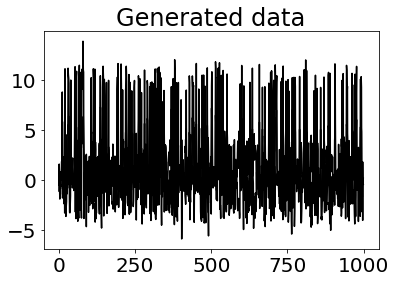

In [37]:
#Generated Data
plt.plot(np.arange(1000),X,c='black')
plt.title('Generated data')

plt.show()

In [38]:
#Training HMM parameters and inferring the hidden states
remodel = hmm.GaussianHMM(n_components=3,covariance_type='full')
remodel.fit(X)
Z2 = remodel.predict(X)
Z2

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 0, 0, 0, 0, 2, 0, 2, 1, 0,
       2, 2, 2, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 2, 2, 2, 2, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 2, 1, 2, 1, 1, 0, 0, 0, 2, 2, 2, 2,
       1, 1, 2, 2, 1, 1, 1, 2, 2, 1, 1, 1, 1, 1, 1, 1, 2, 2, 0, 0, 0, 0,
       0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 1, 2, 0, 2,
       0, 2, 2, 1, 1, 1, 2, 0, 1, 2, 2, 2, 0, 2, 0, 0, 0, 0, 2, 0, 0, 0,
       2, 2, 0, 1, 1, 1, 2, 2, 2, 0, 0, 0, 1, 1, 1, 2, 0, 1, 1, 0, 0, 0,
       0, 2, 1, 0, 2, 0, 0, 0, 0, 1, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0,
       0, 2, 2, 2, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0,
       0, 0, 0, 0, 0, 1, 1, 1, 0, 2, 2, 1, 2, 2, 2, 2, 0, 0, 0, 2, 2, 1,
       1, 1, 1, 2, 2, 2, 2, 0, 0, 1, 1, 2, 1, 1, 1, 2, 2, 2, 0, 1, 0, 0,
       0, 0, 2, 2, 0, 1, 1, 0, 0, 0, 0, 0, 2, 0, 0, 2, 2, 0, 0, 1, 1, 1,
       0, 0, 1, 0, 0, 2, 2, 1, 2, 2, 0, 0, 0, 0, 0, 2, 2, 1, 0, 0, 0, 2,
       2, 2, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 2, 1,

In [39]:
'''
Pi : Fair dice is as likely as biased dice

A  : The dice thrower likes to keep in one state (fair/biased), 
and the tranisition from 
1. Fair-> Fair : .95
2. Fair->Biased: 1-.95=.05
3. Biased->Biased: .90
4. Biased->Biased=1-.90=.10

B  : The fair dice is equally likely to produce 
observations 1 through 6, for the biased dice
Pr(6)=0.5 and Pr(1)=Pr(2)=Pr(3)=Pr(4)=Pr(5)=0.1
'''
pi=np.array([1.0/2,1.0/2])
A=np.array([[.95,.05],[.1,.9]])
B=np.array([[1.0/6 for i in range(6)],[.1,.1,.1,.1,.1,.5]])

In [40]:
'''
Returns next state according to weigted probability array.
'''
def next_state(weights):
    choice = random.random() * sum(weights)
    for i, w in enumerate(weights):
        choice -= w
        if choice < 0:
            return i

In [41]:
count=0
for i in range(1000):
    count+=next_state(pi)
print ("Expected number of Fair states:",1000-count)
print ("Expected number of Biased states:",count)

Expected number of Fair states: 495
Expected number of Biased states: 505


In [42]:
def create_hidden_sequence(pi,A,length):
    out=[None]*length
    out[0]=next_state(pi)
    for i in range(1,length):
        out[i]=next_state(A[out[i-1]])
    return out
   
def create_observation_sequence(hidden_sequence,B):
    length=len(hidden_sequence)
    out=[None]*length
    for i in range(length):
        out[i]=next_state(B[hidden_sequence[i]])
    return out

In [43]:
hidden=np.array(create_hidden_sequence(pi,A,1000))
observed=np.array(create_observation_sequence(hidden,B))

In [44]:
'''Group all contiguous values in tuple.'''
def group(L):
    first = last = L[0]
    for n in L[1:]:
        if n - 1 == last: # Part of the group, bump the end
            last = n
        else: # Not part of the group, yield current group and start a new
            yield first, last
            first = last = n
    yield first, last # Yield the last group
    
'''Create tuples of the form (start, number_of_continuous values'''
def create_tuple(x):
    return [(a,b-a+1) for (a,b) in x]

In [45]:
#Tuples of form index value, number of continuous values 
#corresponding to Fair State
indices_hidden_fair=np.where(hidden==0)[0]
tuples_contiguous_values_fair=list(group(indices_hidden_fair))
tuples_start_break_fair=create_tuple(tuples_contiguous_values_fair)

#Tuples of form index value, number of continuous 
#values corresponding to Biased State
indices_hidden_biased=np.where(hidden==1)[0]
tuples_contiguous_values_biased=list(group(indices_hidden_biased))
tuples_start_break_biased=create_tuple(tuples_contiguous_values_biased)

#Tuples for observations
observation_tuples=[]
for i in range(6):
    observation_tuples.append(create_tuple(group(list(np.where(observed==i)[0]))))

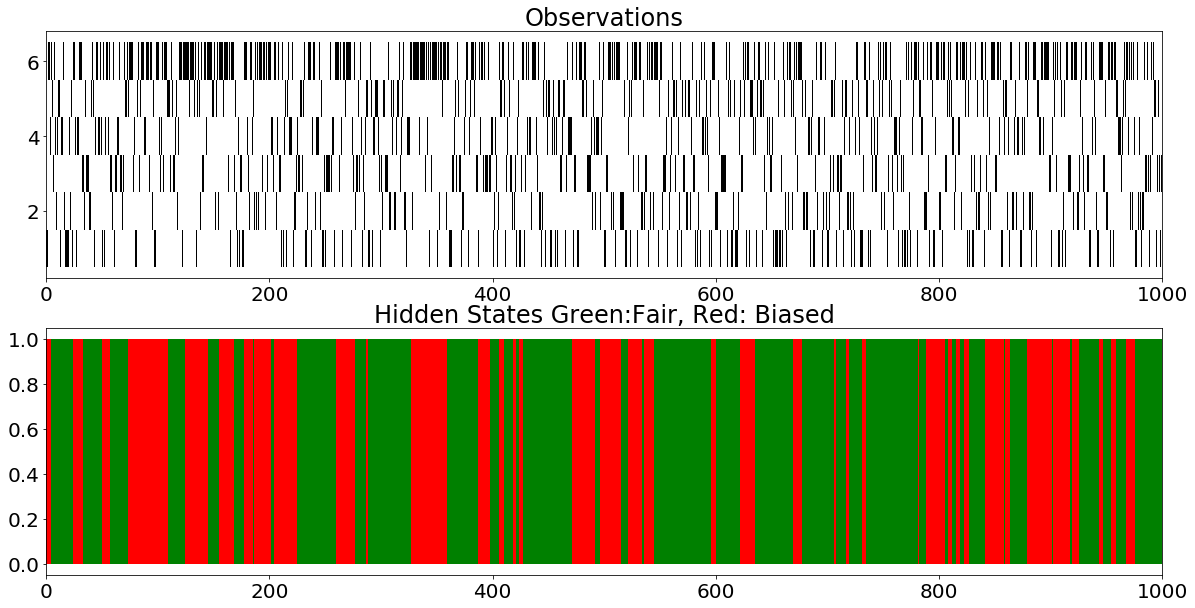

In [46]:
fig, ax = plt.subplots(figsize=(20, 10))
plt.subplot(2,1,1)
plt.xlim((0,1000));
plt.title('Observations');
for i in range(6):
    plt.broken_barh(observation_tuples[i],(i+0.5,1),facecolor='k');
plt.subplot(2,1,2);
plt.xlim((0,1000));
plt.title('Hidden States Green:Fair, Red: Biased');
plt.broken_barh(tuples_start_break_fair,(0,1),facecolor='g');
plt.broken_barh(tuples_start_break_biased,(0,1),facecolor='r');